<a href="https://colab.research.google.com/github/wl2748/5242_project/blob/main/CNN_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from keras import backend as K

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


In [ ]:
class DataProcessing:
    def __init__(self, file, train):
        self.file = file                                # 读取数据
        self.train = train                              # 训练集所占比例     
        self.i = int(self.train * len(self.file))       # 训练集大小（具体数字）
        self.stock_train = self.file[0: self.i]         # 得到训练集
        self.stock_test = self.file[self.i:]            # 得到测试集
        self.input_train = []
        self.output_train = []
        self.input_test = []
        self.output_test = []

    def gen_train(self, seq_len):
        """
        Generates training data
        :param seq_len: length of window
        :return: X_train and Y_train
        """
        for i in range((len(self.stock_train)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_train.iloc[i: i+seq_len])
            y = np.array([self.stock_train.iloc[i+seq_len]], np.float64)
            self.input_train.append(x)
            self.output_train.append(y)
        self.X_train = np.array(self.input_train)
        self.Y_train = np.array(self.output_train)

    def gen_test(self, seq_len):
        """
        Generates test data
        :param seq_len: Length of window
        :return: X_test and Y_test
        """
        for i in range((len(self.stock_test)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_test.iloc[i: i+seq_len], np.float64)
            y = np.array([self.stock_test.iloc[i+seq_len]], np.float64)
            self.input_test.append(x)
            self.output_test.append(y)
        self.X_test = np.array(self.input_test)
        self.Y_test = np.array(self.output_test)

In [ ]:
national_debt = pd.read_excel('中债国债收益率曲线.xls', parse_dates=True)
national_debt = national_debt.iloc[1:4664,1:]
national_debt_s = national_debt.iloc[:,:national_debt.shape[1]-2].dropna()
national_debt_l = national_debt.iloc[:,national_debt.shape[1]-2:].dropna()

In [ ]:
data = pd.DataFrame(national_debt_s.iloc[:,15])
data.head()

,中债国债到期收益率:10年
1060,2.9291
1069,3
1070,3.048
1071,3.05
1076,3


In [ ]:

### standardize the data:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = pd.DataFrame(scaler.fit_transform(data))

In [ ]:
p = 0.8
n = 50
e = 100
process_data = DataProcessing(data_scaled, p)
process_data.gen_test(n)
process_data.gen_train(n)
    
# reshape训练集和测试集，用来建立模型ß
r_train = int((len(data)*p//n)*n - n - 1)
r_test = int((len(data)*(1-p)//n)*n - n - 1)
x_train = process_data.X_train.reshape((r_train,n,1))
y_train = process_data.Y_train.reshape((r_train,1,1))
x_test = process_data.X_test.reshape((r_test,n,1))
y_test = process_data.Y_test.reshape((r_test,1,1))

# 将数据转化成可用于 Tensorflow 使用的 float 形式：
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_test = K.cast_to_floatx(x_test)
y_test = K.cast_to_floatx(y_test)

In [ ]:

### 建立一个callback的class：
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<1e-7):
      print('\nLoss is low so cancelling training!')
      self.model.stop_training = True
callbacks = myCallback()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
model_cnn = tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides = 1, padding = 'same' ,activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides = 1, padding = 'same',activation='relu'),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides = 1, padding = 'same',activation='relu'),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(50, activation='relu'),
                tf.keras.layers.Dropout(.2),
                tf.keras.layers.Dense(5, activation = 'relu'),
                tf.keras.layers.Dense(1, activation='relu')

])

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 128)           24704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0

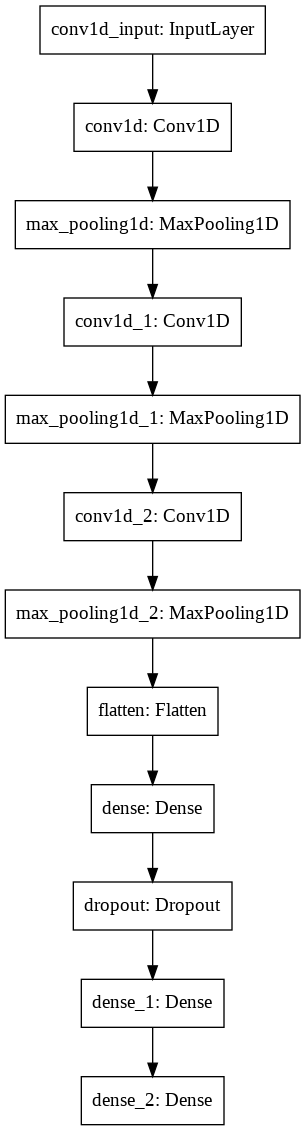

In [ ]:
tf.keras.utils.plot_model(model_cnn)

In [ ]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss="mean_squared_error")

In [ ]:
history = model_cnn.fit(train.shuffle(10000).repeat(10).batch(64).prefetch(1), epochs=e, verbose=2,validation_data=(x_test, y_test)
                     , callbacks=[early_stopping_cb])


Epoch 1/100
430/430 - 1s - loss: 0.0157 - accuracy: 1.0913e-04 - val_loss: 0.0014 - val_accuracy: 0.0015
Epoch 2/100
430/430 - 1s - loss: 0.0043 - accuracy: 7.2754e-05 - val_loss: 5.1319e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
430/430 - 1s - loss: 0.0027 - accuracy: 7.2754e-05 - val_loss: 3.7194e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
430/430 - 1s - loss: 0.0020 - accuracy: 1.0913e-04 - val_loss: 4.0739e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
430/430 - 1s - loss: 0.0016 - accuracy: 1.4551e-04 - val_loss: 4.6083e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
430/430 - 1s - loss: 0.0015 - accuracy: 3.6377e-05 - val_loss: 3.4564e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
430/430 - 1s - loss: 0.0014 - accuracy: 7.2754e-05 - val_loss: 5.3199e-04 - val_accuracy: 0.0000e+00
Epoch 8/100
430/430 - 1s - loss: 0.0013 - accuracy: 1.4551e-04 - val_loss: 5.5584e-04 - val_accuracy: 0.0000e+00
Epoch 9/100
430/430 - 1s - loss: 0.0013 - accuracy: 3.6377e-05 - val_loss: 5.5862e-04 - val_accuracy: 0.

In [ ]:
test_predict = pd.DataFrame(model_cnn.predict(x_test))
data_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(test_predict.iloc[:,0])))

In [ ]:
test_y = scaler.inverse_transform(pd.DataFrame(((y_test)).reshape(r_test,1).tolist()))
test_y = pd.DataFrame(test_y)

In [ ]:
from scipy import stats
stats.ttest_ind(data_predict, test_y)

Ttest_indResult(statistic=array([0.23049355]), pvalue=array([0.81774465]))

No handles with labels found to put in legend.


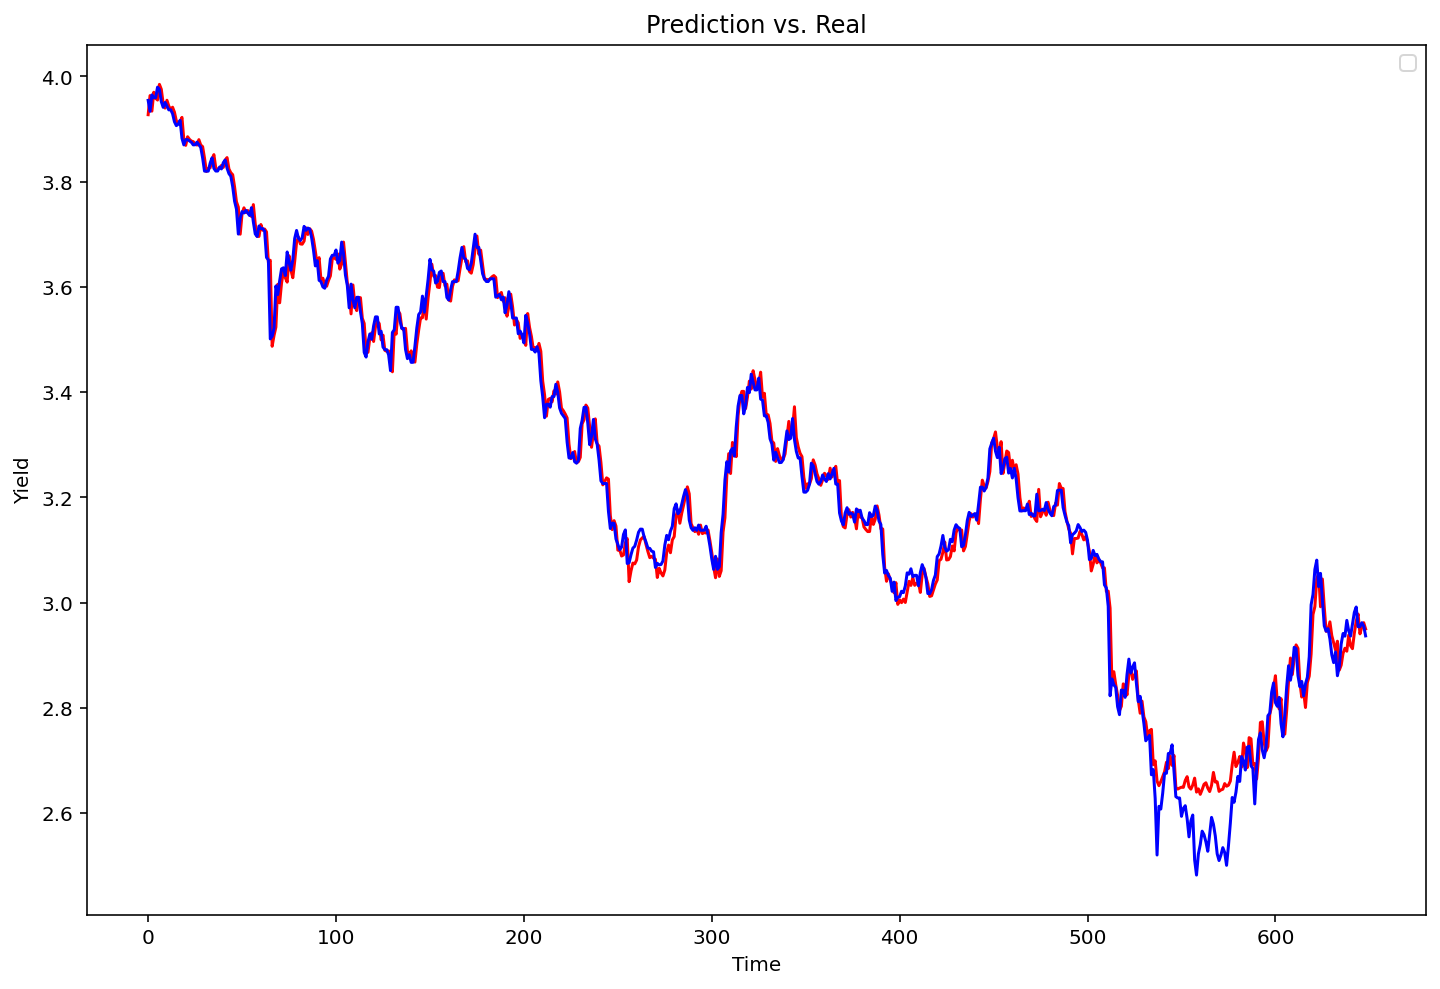

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(data_predict, color='red')
plt.plot(test_y, color='blue')
plt.title('Prediction vs. Real')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend();

In [ ]:
x_train.shape[0]

2749

In [ ]:
#backtesting

In [ ]:
#Start from 2/3 timestamps

t = int(2*x_train.shape[0]/3)

prediction = []

while t<x_train.shape[0]:
    model_cnn.fit(x_train[:t], y_train[:t], epochs=e, verbose=1 if t % 100 == 0 else 0,validation_data=(x_test, y_test), callbacks=[early_stopping_cb])
    pred = model_cnn.predict(np.expand_dims(x_train[t], 0)).squeeze()
    prediction.append(pred)
    t+=1

Epoch 1/100
60/60 [==============================] - 0s 4ms/step - loss: 1.4929e-04 - val_loss: 0.0029
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 8.6140e-05 - val_loss: 0.0030
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 6.4751e-05 - val_loss: 0.0031
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 7.9616e-05 - val_loss: 0.0030
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 6.2485e-05 - val_loss: 0.0029
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 6.5568e-05 - val_loss: 0.0031
Epoch 1/100
63/63 [==============================] - 0s 4ms/step - loss: 6.5591e-05 - val_loss: 0.0034
Epoch 2/100
63/63 [==============================] - 0s 4ms/step - loss: 6.5922e-05 - val_loss: 0.0031
Epoch 3/100
63/63 [==============================] - 0s 4ms/step - loss: 6.6240e-05 - val_loss: 0.0032
Epoch 4/100
63/63 [==============================] - 0s 4ms/step - loss: 

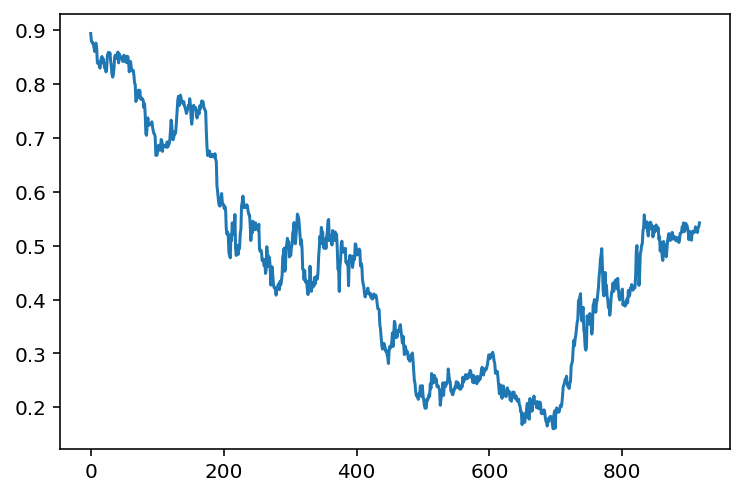

In [ ]:
plt.plot(prediction)

In [ ]:
np.mean((prediction-y_train[int(x_train.shape[0]/3):].squeeze())**2)

In [ ]:
np.savetxt('prediction', prediction)

In [ ]:
%cd /content/drive/MyDrive/GR5242_AML/Project